In [2]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# set the random seed - consistent
rs = 10

Loading the pickle

In [3]:
import pickle
with open('data.pickle', 'rb') as f:
    best_dt, X, X_v2_train, X_v2_test, Y_v2_train, Y_v2_test = pickle.load(f)


In [4]:
# setting random state
rs = 10

X_train, X_test, y_train, y_test = X_v2_train, X_v2_test, Y_v2_train, Y_v2_test

Build a regression model using the default regression method


In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
model = LogisticRegression(random_state=rs)

# fit it to training data
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=10, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
# training and test accuracy
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

# classification report on test data
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

Train accuracy: 0.5911730545876888
Test accuracy: 0.5962059620596206
              precision    recall  f1-score   support

           0       0.62      0.69      0.65       202
           1       0.56      0.48      0.52       167

    accuracy                           0.60       369
   macro avg       0.59      0.59      0.59       369
weighted avg       0.59      0.60      0.59       369



In [9]:
# grab feature importances from the model and feature name from the original X
coef = model.coef_[0]
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

# limit to 20 features, you can leave this out to print out everything
indices = indices[:20]

for i in indices:
    print(feature_names[i], ':', coef[i])

Leukocytes : -0.8449944439155792
Influenza A rapid test_positive : -0.6407945994913161
Influenza A rapid test_negative : 0.6407945994913156
Eosinophils : -0.4872827122576538
Influenza B rapid test_negative : 0.397747607018168
Influenza B rapid test_positive : -0.3977476070181676
Platelets : -0.26568942505536675
Proteina C reativa : 0.25524006185238013
Patient age quantile : 0.24003655254146694
Mean corpuscular volume : -0.18825739430993263
Red blood Cells : -0.18232365414519805
Lymphocytes : 0.17771935245020712
Basophils : -0.10689930497400708
Monocytes : -0.06805159208184668
Mean corpuscular hemoglobin concentration : 0.03105944835186461
Mean platelet volume : -0.02344270084654843
Red blood cell distribution width : -0.016773185380241196


Build a regression model using the default regression method tuned with GridSearchCV


In [10]:
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

# use all cores to tune logistic regression with C parameter
cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs),return_train_score=True, cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=10, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                               100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

Total number of models:  10


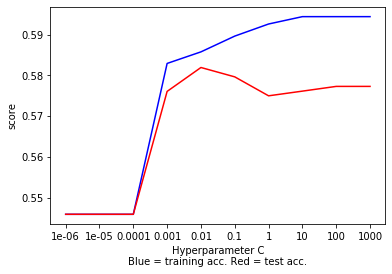

In [11]:
result_set = cv.cv_results_
import matplotlib.pyplot as plt
train_result = result_set['mean_train_score']
test_result = result_set['mean_test_score']
print("Total number of models: ", len(test_result))
# plot Hyperparameter C values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)), test_result, 'r')
plt.xlabel('Hyperparameter C\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),[pow(10, x) for x in range(-6, 4)])
plt.ylabel('score')
plt.show()

In [12]:
print(cv.best_params_)

{'C': 0.01}


In [13]:

print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

Train accuracy: 0.5876887340301974
Test accuracy: 0.5962059620596206


Build a regression model on the reduced variables set by Recursive feature elimination. 

In [14]:
from sklearn.feature_selection import RFECV

rfe = RFECV(estimator = LogisticRegression(random_state=rs), cv=10)
rfe.fit(X_train, y_train) # run the RFECV

# comparing how many variables before and after
print("Original feature set", X_train.shape[1])
print("Number of features after elimination", rfe.n_features_)

Original feature set 17
Number of features after elimination 5


In [15]:
X_train_sel = rfe.transform(X_train)
X_test_sel = rfe.transform(X_test)

In [16]:
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

rfe_cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
rfe_cv.fit(X_train_sel, y_train)

# test the best model
print("Train accuracy:", rfe_cv.score(X_train_sel, y_train))
print("Test accuracy:", rfe_cv.score(X_test_sel, y_test))

y_pred = rfe_cv.predict(X_test_sel)
print(classification_report(y_test, y_pred))

# print parameters of the best model
print(rfe_cv.best_params_)

Train accuracy: 0.5830429732868757
Test accuracy: 0.5691056910569106
              precision    recall  f1-score   support

           0       0.56      0.96      0.71       202
           1       0.67      0.10      0.17       167

    accuracy                           0.57       369
   macro avg       0.61      0.53      0.44       369
weighted avg       0.61      0.57      0.46       369

{'C': 0.01}


In [17]:
##Report the top-5 important variables (in the order) in the model
# grab feature importances from the model and feature name from the original X
coef = rfe.grid_scores_
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

# limit to 20 features, you can leave this out to print out everything
indices = indices[:20]

for i in indices:
    print(feature_names[i], ':', coef[i])


Red blood Cells : 0.5818631381983428
Red blood cell distribution width : 0.5818631381983428
Mean platelet volume : 0.5783747661053196
Lymphocytes : 0.5772788024592356
Mean corpuscular hemoglobin concentration : 0.5772788024592356
Leukocytes : 0.5761026463512431
Influenza A rapid test_positive : 0.5749665864742048
Influenza B rapid test_positive : 0.5749665864742048
Influenza B rapid test_negative : 0.5749665864742048
Influenza A rapid test_negative : 0.5749665864742048
Mean corpuscular volume : 0.5749532210638868
Basophils : 0.5749398556535686
Monocytes : 0.5748863940122962
Platelets : 0.5748730286019781
Eosinophils : 0.5714648489708635
Proteina C reativa : 0.570302058273189
Patient age quantile : 0.5458834536220263


Score of models

In [18]:
from sklearn.metrics import roc_auc_score

y_pred_proba_lr = model.predict_proba(X_test)
y_pred_proba_lr_cv = cv.predict_proba(X_test)
y_pred_proba_rfe_cv = rfe_cv.predict_proba(X_test_sel)



roc_index_lr = roc_auc_score(y_test, y_pred_proba_lr[:, 1])
roc_index_lr_cv = roc_auc_score(y_test, y_pred_proba_lr_cv[:, 1])
roc_index_rfe_cv = roc_auc_score(y_test, y_pred_proba_rfe_cv[:, 1])


print("ROC index on test for `model`:", roc_index_lr)
print("ROC index on test for `cv`:", roc_index_lr_cv)
print("ROC index on test for `rfe_cv`:", roc_index_rfe_cv)


ROC index on test for `model`: 0.7046451651153139
ROC index on test for `cv`: 0.7097438785794747
ROC index on test for `rfe_cv`: 0.6561332779984586


In [19]:
from sklearn.metrics import roc_curve

fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_proba_lr[:,1])
fpr_lr_cv, tpr_lr_cv, thresholds_lr_cv = roc_curve(y_test, y_pred_proba_lr_cv[:,1])
fpr_rfe_cv, tpr_rfe_cv, thresholds_rfe_cv = roc_curve(y_test, y_pred_proba_rfe_cv[:,1])


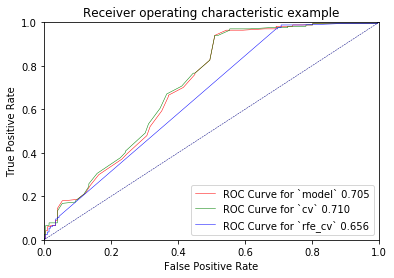

In [20]:
import matplotlib.pyplot as plt

plt.plot(fpr_lr, tpr_lr, label='ROC Curve for `model` {:.3f}'.format(roc_index_lr), color='red', lw=0.5)
plt.plot(fpr_lr_cv, tpr_lr_cv, label='ROC Curve for `cv` {:.3f}'.format(roc_index_lr_cv), color='green', lw=0.5)
plt.plot(fpr_rfe_cv, tpr_rfe_cv, label='ROC Curve for `rfe_cv` {:.3f}'.format(roc_index_rfe_cv), color='blue', lw=0.5)



plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [23]:
best_lr =rfe_cv
with open('best_lc.pickle', 'wb') as f:
    pickle.dump([roc_index_rfe_cv,fpr_rfe_cv, tpr_rfe_cv], f)